In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [8]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [9]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

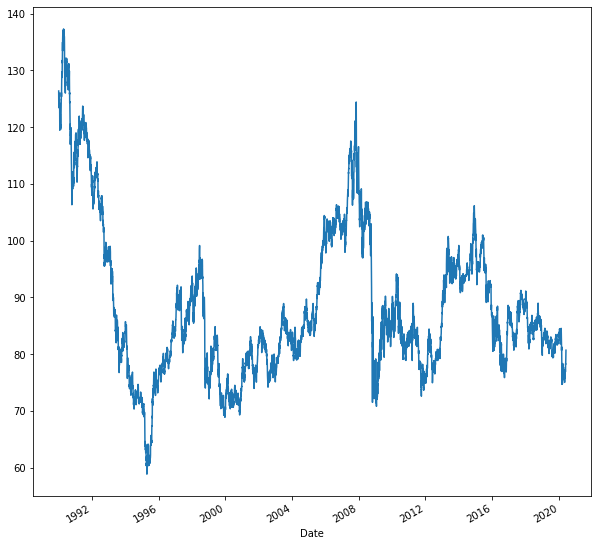

In [10]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(10,10))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** YOUR ANSWER HERE

--- The graph above does not show any patterns in the long and short term, which there is no periodic feature or seasonality. 

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [11]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
price_noise, price_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [12]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
ex_r_price = pd.DataFrame(data=cad_jpy_df.Price)
noise = price_noise
trend = price_trend
ex_r_price['Noise'] = noise
ex_r_price['Trend'] = trend
ex_r_price.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs Trend'}, xlabel='Date'>

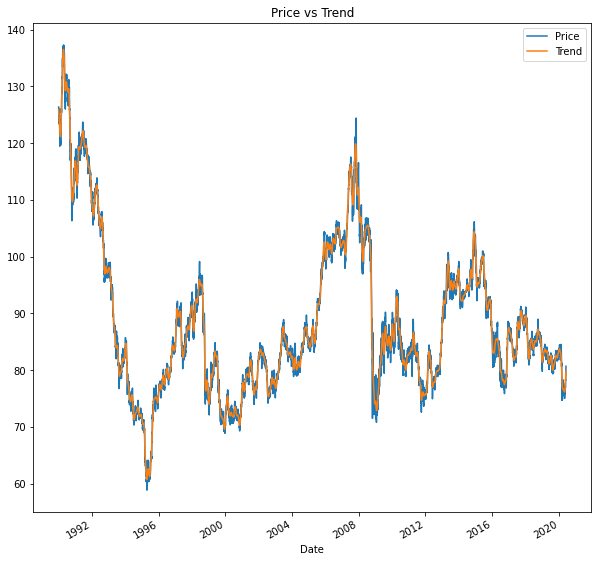

In [13]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to 2020
ex_r_price.plot(y=["Price", "Trend"], title="Price vs Trend", figsize=(10,10))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** After the variable 'trend' is added, there is still no any patterns in the long-run and shor-run.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

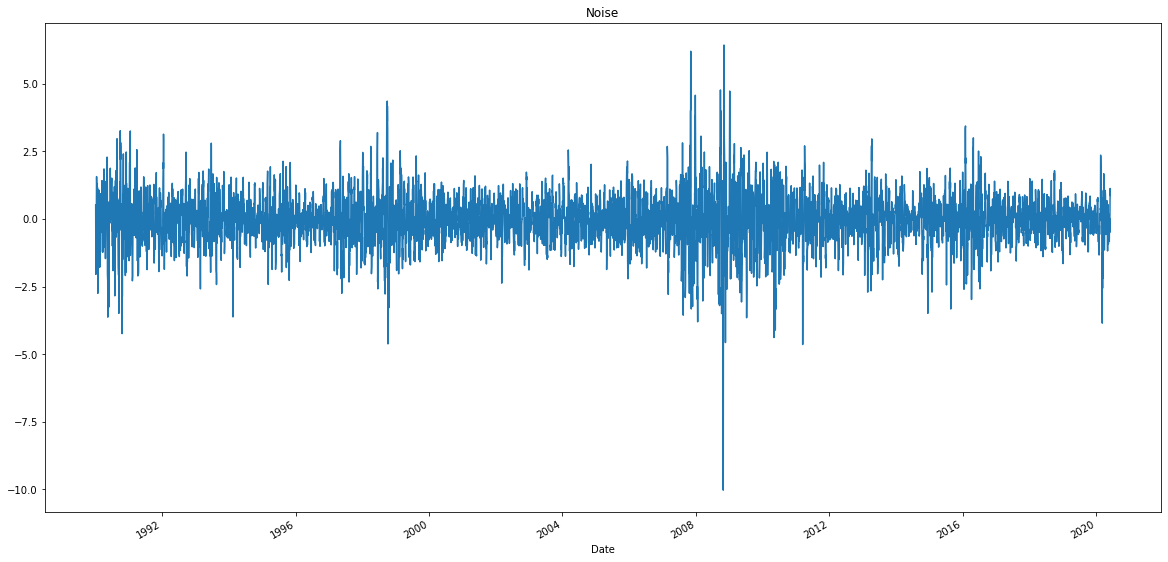

In [14]:
# Plot the Settle Noise
price_noise.plot(title= "Noise", figsize=(20,10))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [15]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [16]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model = ARMA(returns['Price'], order=(2, 1))

# Fit the model and assign it to a variable called results
results = arma_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45590D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.57714D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.51541D-04

At iterate   15    f=  1.23007D+00    |proj g|=  7.78044D-05

At iterate   20    f=  1.23007D+00    |proj g|=  1.55431D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   4.441D-08   1.230D+00
  F =   1.2300678291598384     

CONVERG

In [17]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 26 Apr 2022   AIC                          19513.955
Time:                        18:55:43   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Price    -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.Price    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Price     0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1705           +0.0000j           42.1705            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

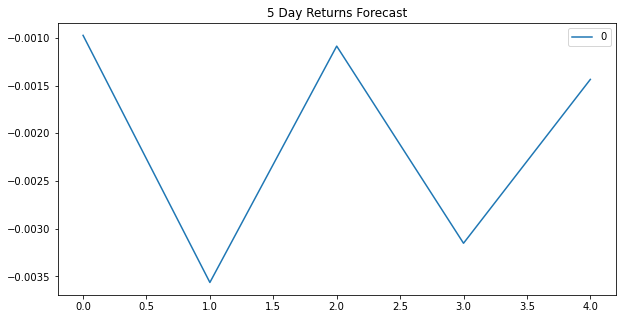

In [18]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast", figsize=(10,5))

**Question:** Based on the p-value, is the model a good fit?



---Bases on the p-value of 0.807 for the constant and 0.14 for the autoregression in the model. It is suggested that under 5% significance level, the p-value is larger than 0.05 which means the historical price data in this model is insignificant over the period to predict the returns. Also, the 'log likelihood' is negative further indicates the model is not a good fit.

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [19]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(ex_r_price['Price'], order=(5,1,1))

# Fit the model
results2 = arima_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10313D+00    |proj g|=  1.92979D-04

At iterate    5    f=  1.10313D+00    |proj g|=  5.81757D-06

At iterate   10    f=  1.10313D+00    |proj g|=  3.35287D-05

At iterate   15    f=  1.10313D+00    |proj g|=  4.79616D-05

At iterate   20    f=  1.10313D+00    |proj g|=  5.77316D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     27      1     0     0   8.882D-08   1.103D+00
  F =   1.1031309576181250     

CONVERG

In [20]:
# Output model summary results:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Tue, 26 Apr 2022   AIC                          17507.244
Time:                        18:55:48   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

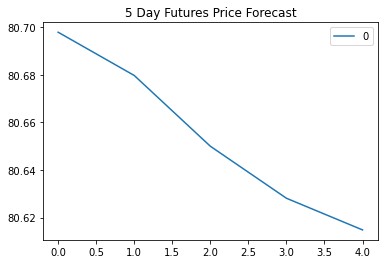

In [21]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results2.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecasts that the Japanese Yen in the near term is going to be dropped significantly. The decreasing autoregressive coefficients overweighs the impact on the increasing coefficients.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [30]:
from arch import arch_model

In [31]:
# Estimate a GARCH model:
model = arch_model(returns, vol='garch', p=2, o=0, q=1)

# Fit the model
results = model.fit(disp="off")

In [32]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8910.28
Distribution:                  Normal   AIC:                           17830.6
Method:            Maximum Likelihood   BIC:                           17865.5
                                        No. Observations:                 7928
Date:                Tue, Apr 26 2022   Df Residuals:                     7927
Time:                        18:57:03   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.3175e-03  7.879e-03      1.183      0.237 [-6.125e-03,2.476e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.1837e-03  2.579e-03      3.560  3.702e-04  [4.128e-03,1.424e-02]
alpha[1]       0.0629  1.853e-02      3.397  6.822e-04  [2.662e-02,9.927e-02]
alpha[2]   6.5836e-12  2.024e-02  3.252e-10      1.000 [-3.967e-02,3.967e-02]
beta[1]        0.9236  1.249e-02     73.934      0.000      [  0.899,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [33]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [34]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [35]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.512045,12.520662,12.529156,12.537532,12.545789


In [36]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.512045
h.2,12.520662
h.3,12.529156
h.4,12.537532
h.5,12.545789


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

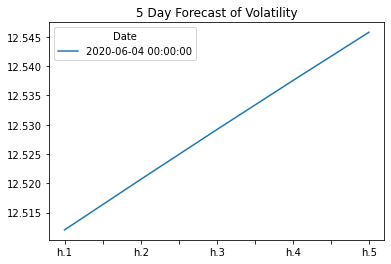

In [38]:
# Plot the final forecast
final.plot(title='5 Day Forecast of Volatility')

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model forecasts that the exchange rate on Japanese Yen will have an increasing uncertainty or risk in changing the exchange rate price. In this prediction, the exchange rate is volatile over the five-day period. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * I would not buy the yen now based on the analysis above. If I buy it now, the model predicted that the price will drop significantly after I bought it, hence I will encounter losses within five days. It is also known that the price is insignificant to estimate returns which means we should not solely rely on price data to predict the returns. Thus, the decision to buy the yen now needs to be further elaborated by other set of data.

2. Is the risk of the yen expected to increase or decrease?
    * Based on the volatility prediction, the risk of the yen is expected to increase. As the standard deviation(sd) of the exchange rate returns is going to be be higher in the near term. The higher the sd, the risker the investment. Hence, the GARCH model helps to indicate that the risk of the yen will increase. 

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * These models employ historical price data to predict and analyse the future price and volatility, which is the easiest method we could use. I am confident to use these models for trading other assets as I am able to capture any potential changes in price and risk. Hence, I could make decisions base on the models.